In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d harlfoxem/housesalesprediction
!unzip housesalesprediction.zip -d /content/drive/MyDrive

Dataset URL: https://www.kaggle.com/datasets/harlfoxem/housesalesprediction
License(s): CC0-1.0
  0% 0.00/780k [00:00<?, ?B/s]
100% 780k/780k [00:00<00:00, 111MB/s]
Archive:  housesalesprediction.zip
replace /content/drive/MyDrive/kc_house_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, boxcox, yeojohnson
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout,LeakyReLU
import keras
import keras_tuner
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras_tuner import RandomSearch,HyperParameters
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
print(f"the data's shape is : {df.shape}")

the data's shape is : (21613, 21)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [ ]:
df.drop(['id'],axis=1,inplace=True)

In [ ]:
print(f"number of duplicated rows : {df.duplicated().sum()}")

number of duplicated rows : 0


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.isnull().sum()

,0
date,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0
view,0
condition,0


In [ ]:
df['date'] = pd.to_datetime(df['date']).dt.year
df['house_age'] = 2024 - df['yr_built']

df['indoor_area'] = df['sqft_living'] + df['sqft_basement']

df['total_area'] = df['sqft_lot']

df['neighbor_area_ratio'] = df['sqft_above'] / (df['sqft_lot15'] + 1e-5)

df['is_waterfront_or_view'] = ((df['waterfront'] > 0) | (df['view'] > 0)).astype(int)

df.drop(['sqft_living', 'sqft_lot', 'sqft_basement','long','lat','date','yr_built','sqft_above','sqft_lot15','waterfront','view'], axis=1, inplace=True)

In [ ]:
round(df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
price,21613.0,540088.14,367127.20,75000.0,321950.00,450000.00,645000.00,7700000.00
bedrooms,21613.0,3.37,0.93,0.0,3.00,3.00,4.00,33.00
bathrooms,21613.0,2.11,0.77,0.0,1.75,2.25,2.50,8.00
floors,21613.0,1.49,0.54,1.0,1.00,1.50,2.00,3.50
condition,21613.0,3.41,0.65,1.0,3.00,3.00,4.00,5.00
grade,21613.0,7.66,1.18,1.0,7.00,7.00,8.00,13.00
yr_renovated,21613.0,84.40,401.68,0.0,0.00,0.00,0.00,2015.00
zipcode,21613.0,98077.94,53.51,98001.0,98033.00,98065.00,98118.00,98199.00
sqft_living15,21613.0,1986.55,685.39,399.0,1490.00,1840.00,2360.00,6210.00
house_age,21613.0,52.99,29.37,9.0,27.00,49.00,73.00,124.00


###EDA

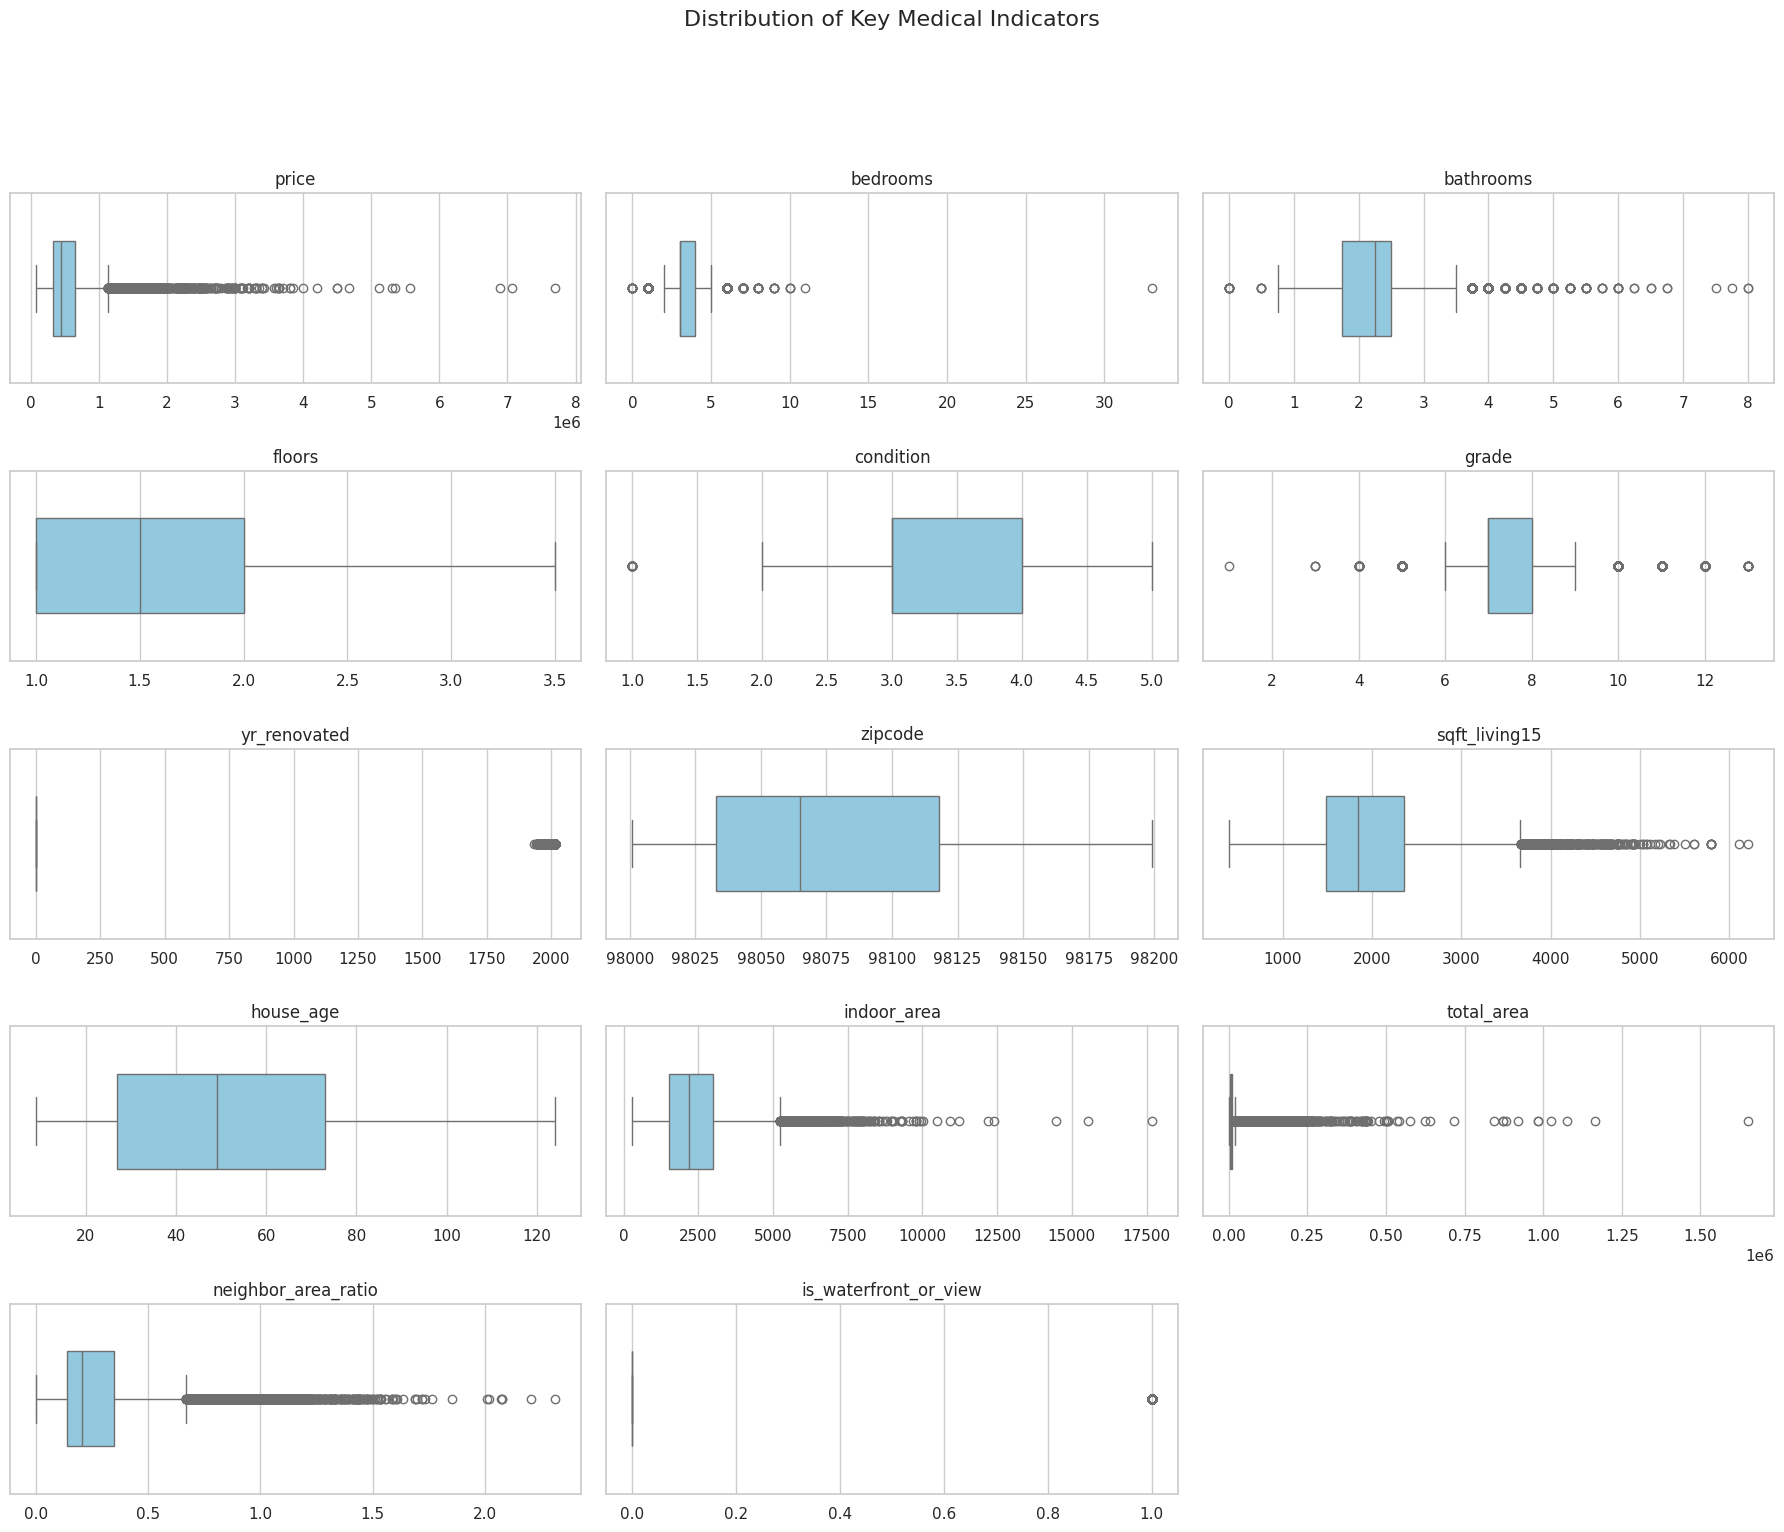

In [ ]:
columns = df.columns
# Calculate the number of rows and columns needed for the subplots
num_cols = 3  # Fixed number of columns
num_rows = math.ceil(len(columns) / num_cols)  # Calculate rows needed

plt.figure(figsize=(18, num_rows * 3))

sns.set_palette("husl")
sns.set(style="whitegrid")

for i, col in enumerate(columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x=df[col], color='skyblue', width=0.5)
    plt.title(col)
    plt.xlabel("")

plt.suptitle("Distribution of Key Medical Indicators", y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
def test_remove_outliers_iqr(data, factor=1.5):
    # Drop NaN values to avoid issues with quantile calculation
    copy_col = data.copy()

    # Calculate the IQR bounds
    q1 = np.quantile(copy_col, 0.25)
    q3 = np.quantile(copy_col, 0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    median_value = copy_col.median()
    # Filter values within bounds and print for debugging
    print(f"for factor = {factor}")
    filtered_data = copy_col.apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)
    print(filtered_data)
    print("-" * 100)
  # data_cleaned = data[(data >= lower_bound) & (data <= upper_bound)]

    return filtered_data

def replace_outliers_with_median_iqr(data, factor=1.5):
    # Drop NaN values to avoid issues with quantile calculation
    q1 = np.quantile(data.dropna(), 0.25)  # Drop NaN values for quantile calculation
    q3 = np.quantile(data.dropna(), 0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr

    # Calculate the median of the original data
    median_value = data.median()

    # Replace outliers with the median value
    data_cleaned = data.apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)

    return data_cleaned

def count_outliers(data, factor=1.5):
    q1 = np.quantile(data.dropna(), 0.25)
    q3 = np.quantile(data.dropna(), 0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    return data[(data < lower_bound) | (data > upper_bound)].count()

In [ ]:
columns_to_handle = ['price','sqft_living15','indoor_area','total_area','neighbor_area_ratio',]


In [ ]:
for col in columns_to_handle:
  print(f"{col} outliers count:")
  print(count_outliers(df[col],factor=1.5))
  print("*"*100)

price outliers count:
1146
****************************************************************************************************
sqft_living15 outliers count:
544
****************************************************************************************************
indoor_area outliers count:
537
****************************************************************************************************
total_area outliers count:
2425
****************************************************************************************************
neighbor_area_ratio outliers count:
1222
****************************************************************************************************


price outliers check:
for factor = 0.5
0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21608    360000.0
21609    400000.0
21610    402101.0
21611    400000.0
21612    325000.0
Name: price, Length: 21613, dtype: float64
----------------------------------------------------------------------------------------------------
for factor = 1
0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21608    360000.0
21609    400000.0
21610    402101.0
21611    400000.0
21612    325000.0
Name: price, Length: 21613, dtype: float64
----------------------------------------------------------------------------------------------------
for factor = 1.25
0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21608    360000.0
21609    400000.0
21610    402101.0
21611    400000.0
21612    325000.0
Name: price, Length: 21613, dtype: float64
---

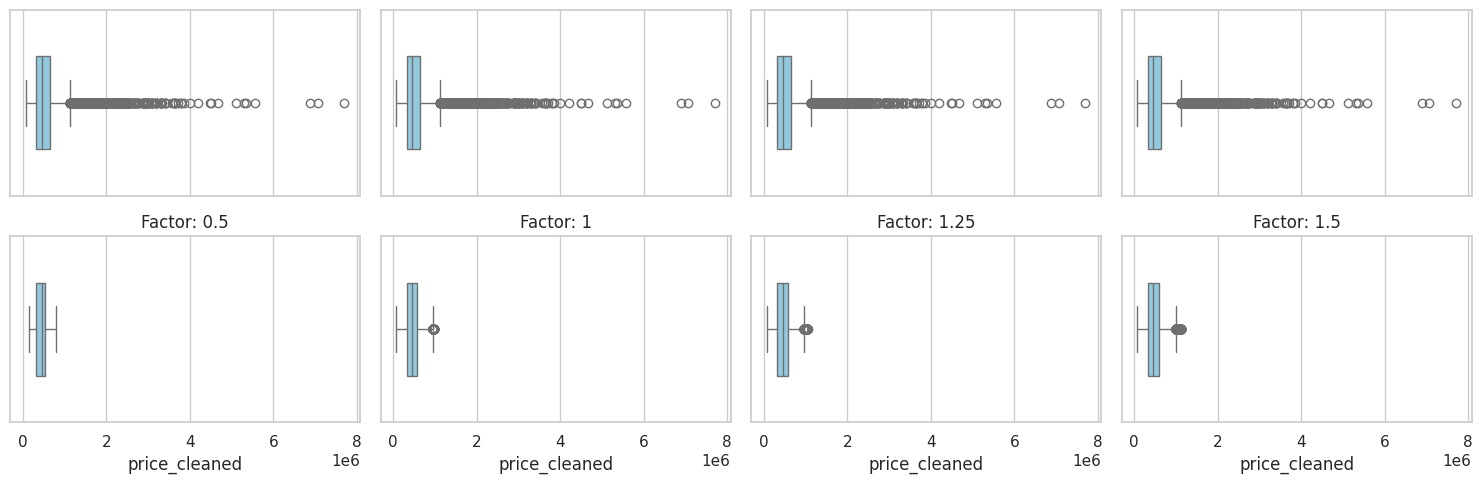

********************************************************************************************************************************************************************************************************


sqft_living15 outliers check:
for factor = 0.5
0        1340.0
1        1690.0
2        2720.0
3        1360.0
4        1800.0
          ...  
21608    1530.0
21609    1830.0
21610    1840.0
21611    1410.0
21612    1840.0
Name: sqft_living15, Length: 21613, dtype: float64
----------------------------------------------------------------------------------------------------
for factor = 1
0        1340.0
1        1690.0
2        2720.0
3        1360.0
4        1800.0
          ...  
21608    1530.0
21609    1830.0
21610    1020.0
21611    1410.0
21612    1020.0
Name: sqft_living15, Length: 21613, dtype: float64
----------------------------------------------------------------------------------------------------
for factor = 1.25
0        1340.0
1        1690.0
2        2720.0
3        1360

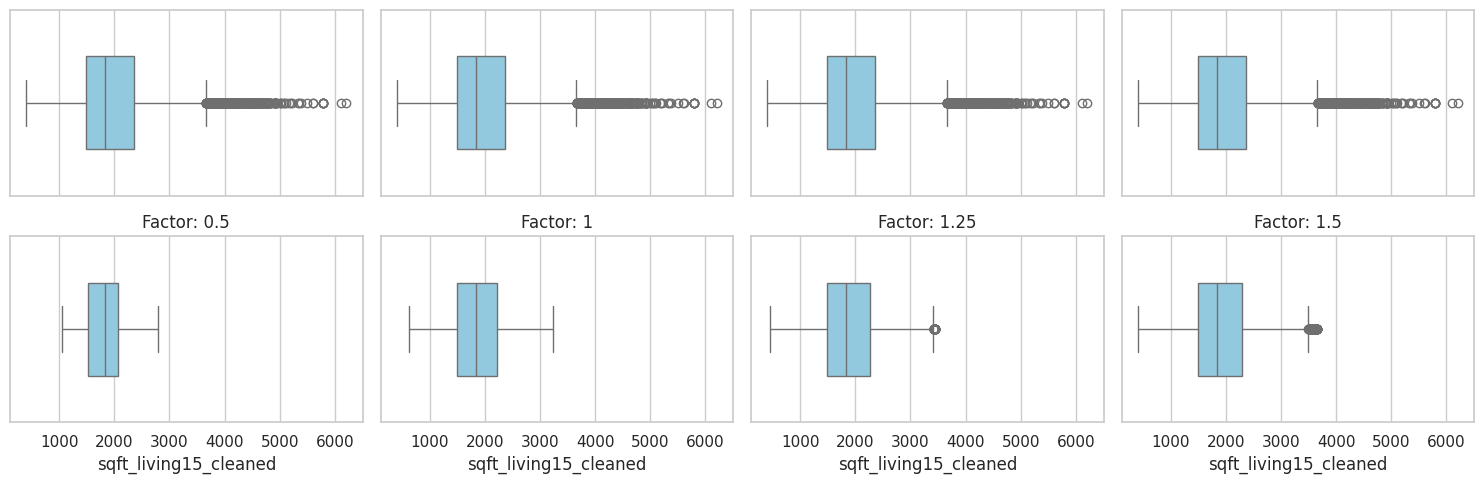

********************************************************************************************************************************************************************************************************


indoor_area outliers check:
for factor = 0.5
0        1180.0
1        2970.0
2         770.0
3        2870.0
4        1680.0
          ...  
21608    1530.0
21609    2310.0
21610    1020.0
21611    1600.0
21612    1020.0
Name: indoor_area, Length: 21613, dtype: float64
----------------------------------------------------------------------------------------------------
for factor = 1
0        1180.0
1        2970.0
2         770.0
3        2870.0
4        1680.0
          ...  
21608    1530.0
21609    2310.0
21610    1020.0
21611    1600.0
21612    1020.0
Name: indoor_area, Length: 21613, dtype: float64
----------------------------------------------------------------------------------------------------
for factor = 1.25
0        1180.0
1        2970.0
2         770.0
3        2870.0
4  

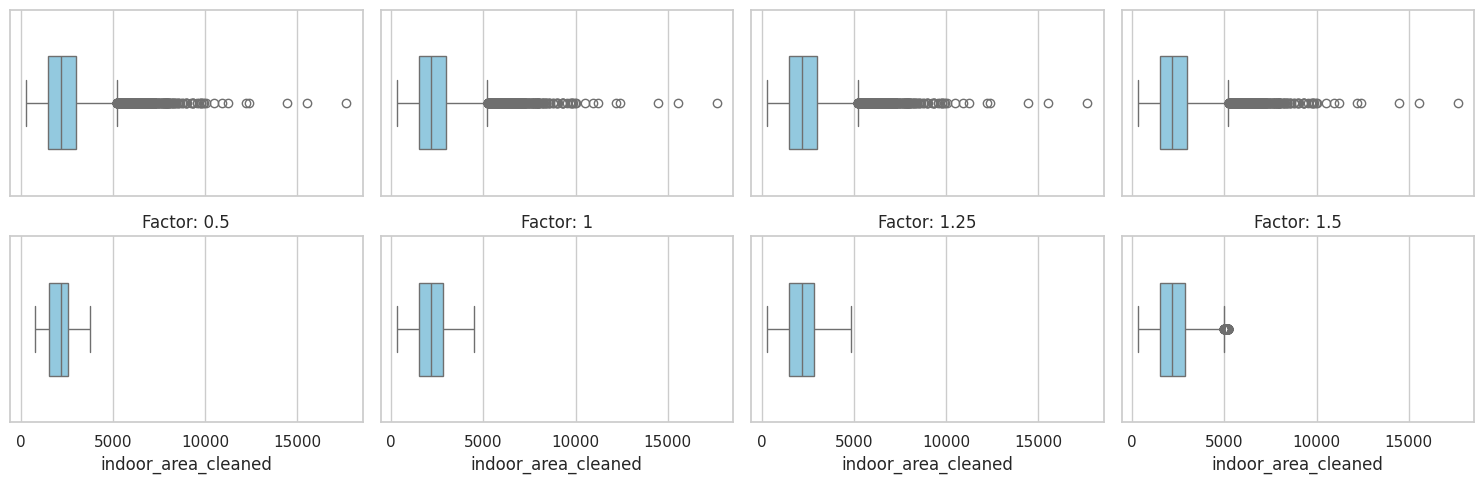

********************************************************************************************************************************************************************************************************


total_area outliers check:
for factor = 0.5
0         5650.0
1         7242.0
2        10000.0
3         5000.0
4         8080.0
          ...   
21608     7618.0
21609     5813.0
21610     7618.0
21611     2388.0
21612     7618.0
Name: total_area, Length: 21613, dtype: float64
----------------------------------------------------------------------------------------------------
for factor = 1
0         5650.0
1         7242.0
2        10000.0
3         5000.0
4         8080.0
          ...   
21608     1131.0
21609     5813.0
21610     1350.0
21611     2388.0
21612     1076.0
Name: total_area, Length: 21613, dtype: float64
----------------------------------------------------------------------------------------------------
for factor = 1.25
0         5650.0
1         7242.0
2        10000

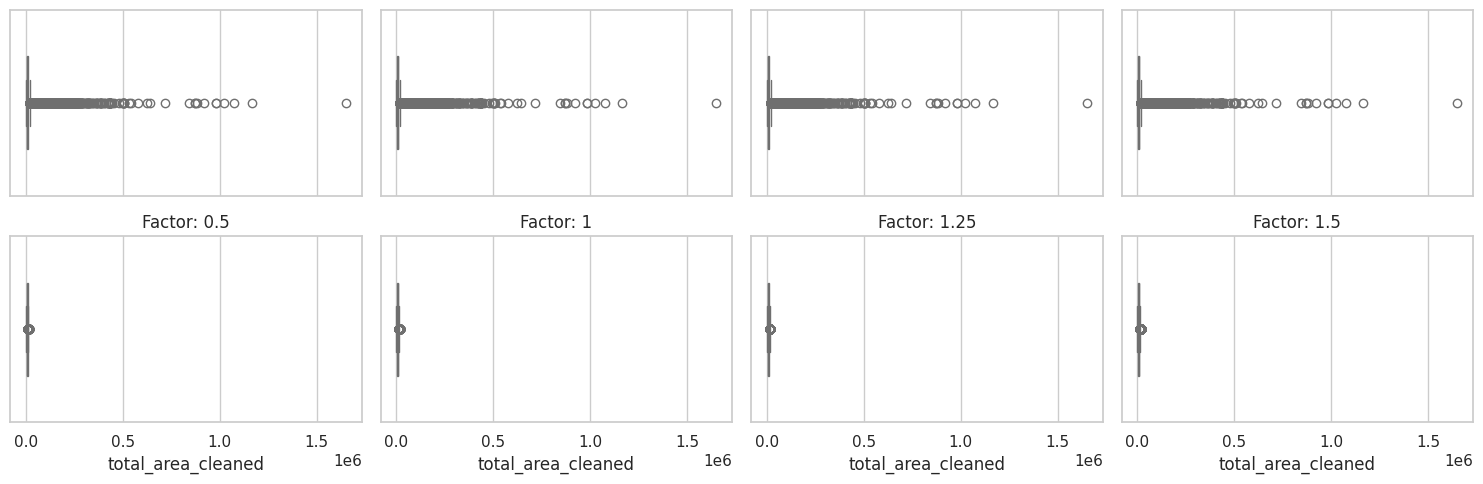

********************************************************************************************************************************************************************************************************


neighbor_area_ratio outliers check:
for factor = 0.5
0        0.208850
1        0.284069
2        0.095510
3        0.210000
4        0.223910
           ...   
21608    0.205053
21609    0.320833
21610    0.205053
21611    0.205053
21612    0.205053
Name: neighbor_area_ratio, Length: 21613, dtype: float64
----------------------------------------------------------------------------------------------------
for factor = 1
0        0.208850
1        0.284069
2        0.095510
3        0.210000
4        0.223910
           ...   
21608    0.205053
21609    0.320833
21610    0.508221
21611    0.205053
21612    0.205053
Name: neighbor_area_ratio, Length: 21613, dtype: float64
----------------------------------------------------------------------------------------------------
for factor = 1.25

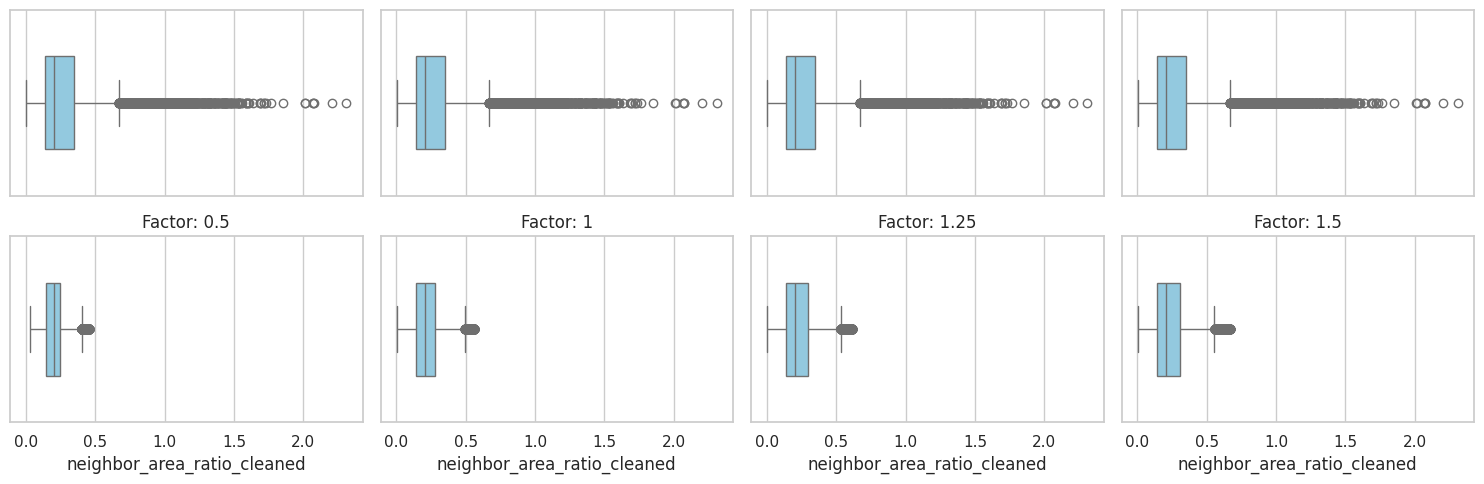

********************************************************************************************************************************************************************************************************




In [ ]:
factor = [0.5,1,1.25,1.5]

for col in columns_to_handle:
  print(f"{col} outliers check:")
  fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 5), sharex=True, sharey=True)
  for i in range(4):
    sns.boxplot(x=df[col],color='skyblue',width=0.5,ax=axes[0,i])
  for i, fact in enumerate(factor):
      df[col+'_cleaned'] = test_remove_outliers_iqr(data=df[col], factor=fact)
      sns.boxplot(x=df[col+'_cleaned'], color='skyblue', width=0.5, ax=axes[1,i])
      axes[1,i].set_title(f"Factor: {fact}")
  plt.tight_layout()
  plt.show()
  print("**"*100)
  print("\n")
  df.drop(col+"_cleaned",axis=1,inplace=True)

**After looking at the above results I decided to choose factor = 1.25 to remove the outliers.**

In [ ]:
print("Original Data Summary Statistics:")
print(df.describe().T,2)

for col in columns_to_handle:
  df[col] = replace_outliers_with_median_iqr(data=df[col], factor=1.25)

print("\nCleaned Data Summary Statistics:")
print(df.describe().T,2)

Original Data Summary Statistics:
                         count           mean            std           min  \
price                  21613.0  540088.141767  367127.196483  75000.000000   
bedrooms               21613.0       3.370842       0.930062      0.000000   
bathrooms              21613.0       2.114757       0.770163      0.000000   
floors                 21613.0       1.494309       0.539989      1.000000   
condition              21613.0       3.409430       0.650743      1.000000   
grade                  21613.0       7.656873       1.175459      1.000000   
yr_renovated           21613.0      84.402258     401.679240      0.000000   
zipcode                21613.0   98077.939805      53.505026  98001.000000   
sqft_living15          21613.0    1986.552492     685.391304    399.000000   
house_age              21613.0      52.994864      29.373411      9.000000   
indoor_area            21613.0    2371.408782    1180.287267    290.000000   
total_area             21613.0

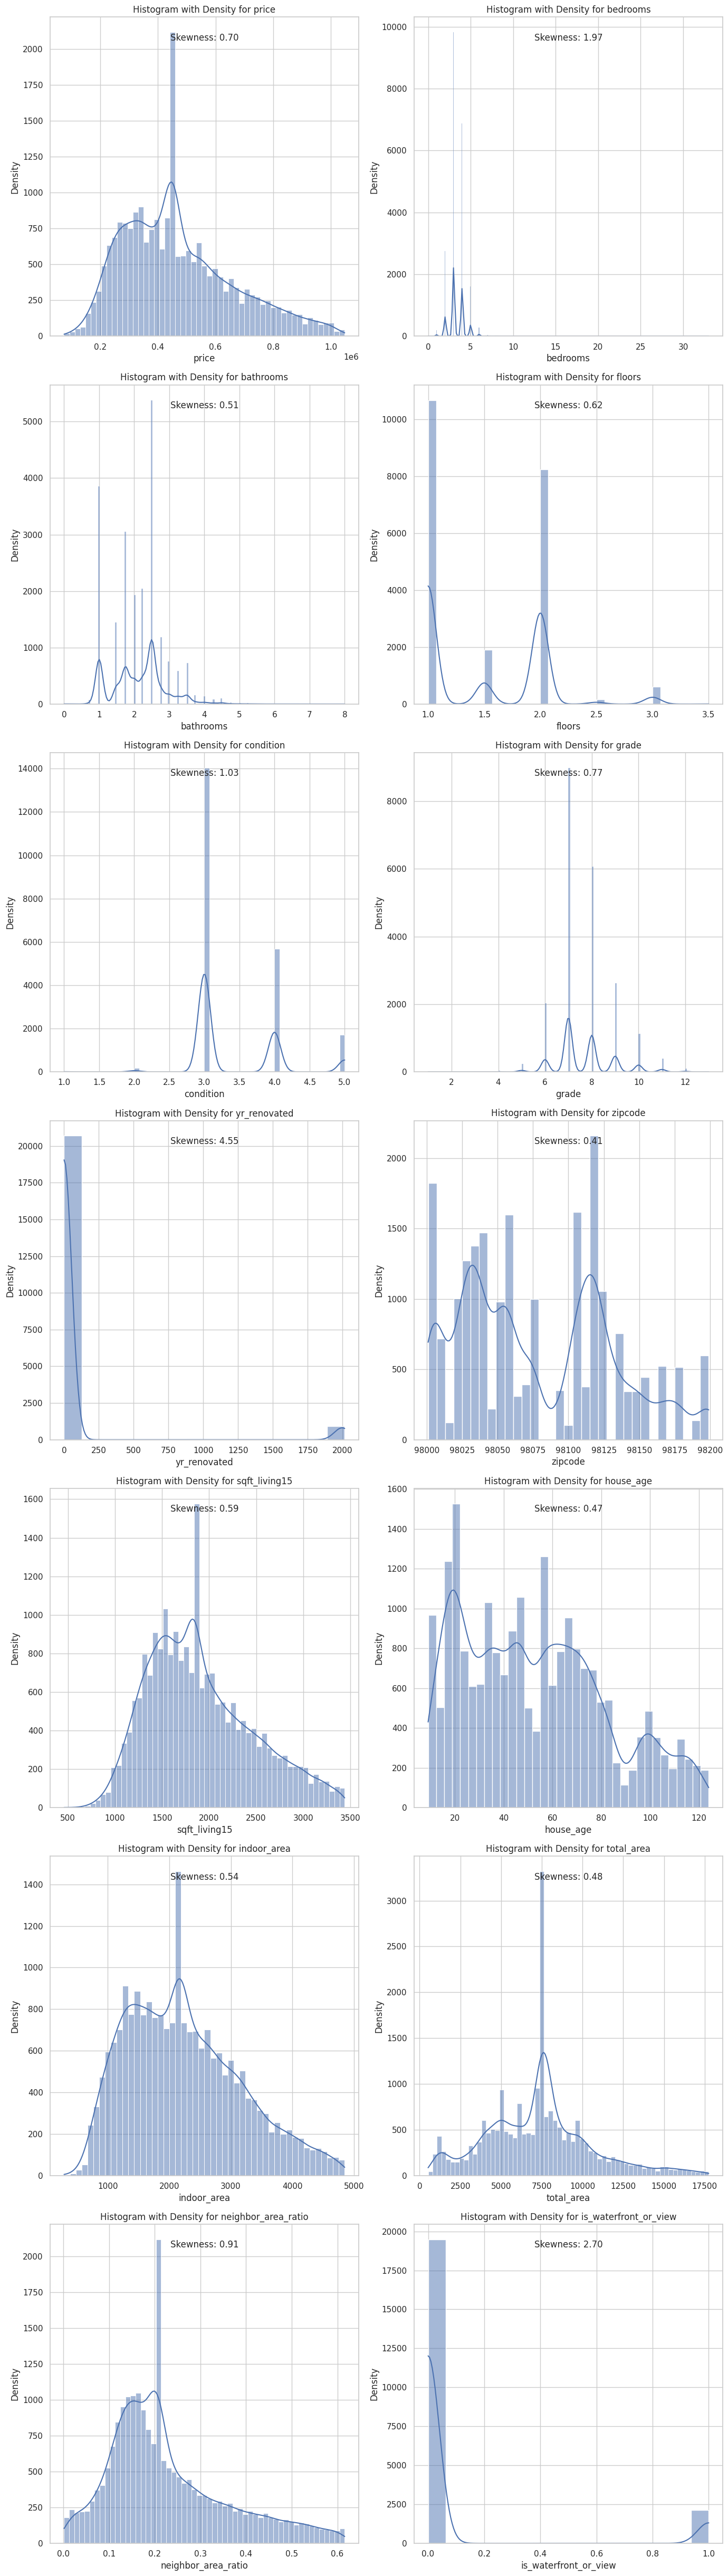

In [ ]:
# Set the figure size and arrange plots horizontally in pairs
numerical_features = df.columns
num_plots = len(numerical_features)
num_rows = (num_plots + 1) // 2  # Ensure enough rows to accommodate all features
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, 7*num_rows))

# Flatten the axes array for easy indexing making it easier to iterate over the subplots using a single index.
axes = axes.flatten()

# Loop through the selected columns and create histograms with density
for i, col in enumerate(numerical_features):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram with Density for {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

    # Calculate skewness
    skewness = skew(df[col].dropna())
    axes[i].text(0.5, 0.95, f'Skewness: {skewness:.2f}', horizontalalignment='center', verticalalignment='top', transform=axes[i].transAxes)

# Remove any empty subplots if the number of features is odd
if num_plots % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [ ]:

def transform(X,threshold=0.5):
    eps = 1e-5
    X_copy = X.copy()
    numerical_columns = X_copy.select_dtypes(include=['float64', 'int64']).columns.tolist()

    for col in numerical_columns:
        if X_copy[col].value_counts().count()==2:
          continue
        skewness = skew(X_copy[col])
        if skewness > threshold:  # Positive skew
            X_copy[col] = np.log(X[col] + eps)
        elif skewness < -threshold:  # Negative skew
            X_copy[col] = np.log(np.max(X[col] + eps) - X[col] + eps)
        else:  # Symmetric or zero skew
            X_copy[col] = X_copy[col]  # No transformation needed

    return X_copy


def boxcox_transform(X):
    X_copy = X.copy()
    numerical_columns = X_copy.select_dtypes(include=['float64', 'int64']).columns.tolist()
    for col in numerical_columns:
        if X_copy[col].value_counts().count()==2:
          continue
        # Only positive data can be transformed with Box-Cox
        if (X_copy[col] > 0).all():
            X_copy[col], _ = boxcox(X_copy[col] + 1e-5)  # Adding a small epsilon to avoid issues with zeros
    return X_copy


def yeojohnson_transform(X):
    X_copy = X.copy()
    numerical_columns = X_copy.select_dtypes(include=['float64', 'int64']).columns.tolist()
    for col in numerical_columns:
      if X_copy[col].value_counts().count()==2:
          continue
      X_copy[col], _ = yeojohnson(X_copy[col])
    return X_copy

def compare_skewness(df_original, df_transformed, label):
    print(f"Skewness comparison for {label}")
    for col in df_original.select_dtypes(include=['float64', 'int64']).columns:
        original_skewness = skew(df_original[col].dropna())
        transformed_skewness = skew(df_transformed[col].dropna())
        print(f"{col}: Original Skewness = {original_skewness:.2f}, Transformed Skewness = {transformed_skewness:.2f}")
    print("\n")

In [ ]:
transform_df = transform(df)
boxcox_df = boxcox_transform(df)
yeojohnson_df = yeojohnson_transform(df)

In [ ]:
compare_skewness(df, transform_df, "Log Transformation")
compare_skewness(df, boxcox_df, "Box-Cox Transformation")
compare_skewness(df, yeojohnson_df, "Yeo-Johnson Transformation")

Skewness comparison for Log Transformation
price: Original Skewness = 0.70, Transformed Skewness = -0.26
bedrooms: Original Skewness = 1.97, Transformed Skewness = -16.65
bathrooms: Original Skewness = 0.51, Transformed Skewness = -8.22
floors: Original Skewness = 0.62, Transformed Skewness = 0.27
condition: Original Skewness = 1.03, Transformed Skewness = 0.34
grade: Original Skewness = 0.77, Transformed Skewness = 0.07
yr_renovated: Original Skewness = 4.55, Transformed Skewness = 4.55
zipcode: Original Skewness = 0.41, Transformed Skewness = 0.41
sqft_living15: Original Skewness = 0.59, Transformed Skewness = -0.04
house_age: Original Skewness = 0.47, Transformed Skewness = 0.47
indoor_area: Original Skewness = 0.54, Transformed Skewness = -0.34
total_area: Original Skewness = 0.48, Transformed Skewness = 0.48
neighbor_area_ratio: Original Skewness = 0.91, Transformed Skewness = -1.36
is_waterfront_or_view: Original Skewness = 2.70, Transformed Skewness = 2.70


Skewness comparison 

<ipython-input-13-dfa43e5d6a78>:45: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  transformed_skewness = skew(df_transformed[col].dropna())


**So after comparing the 3 transformation we will use the Yeo-Johnson Transformation**

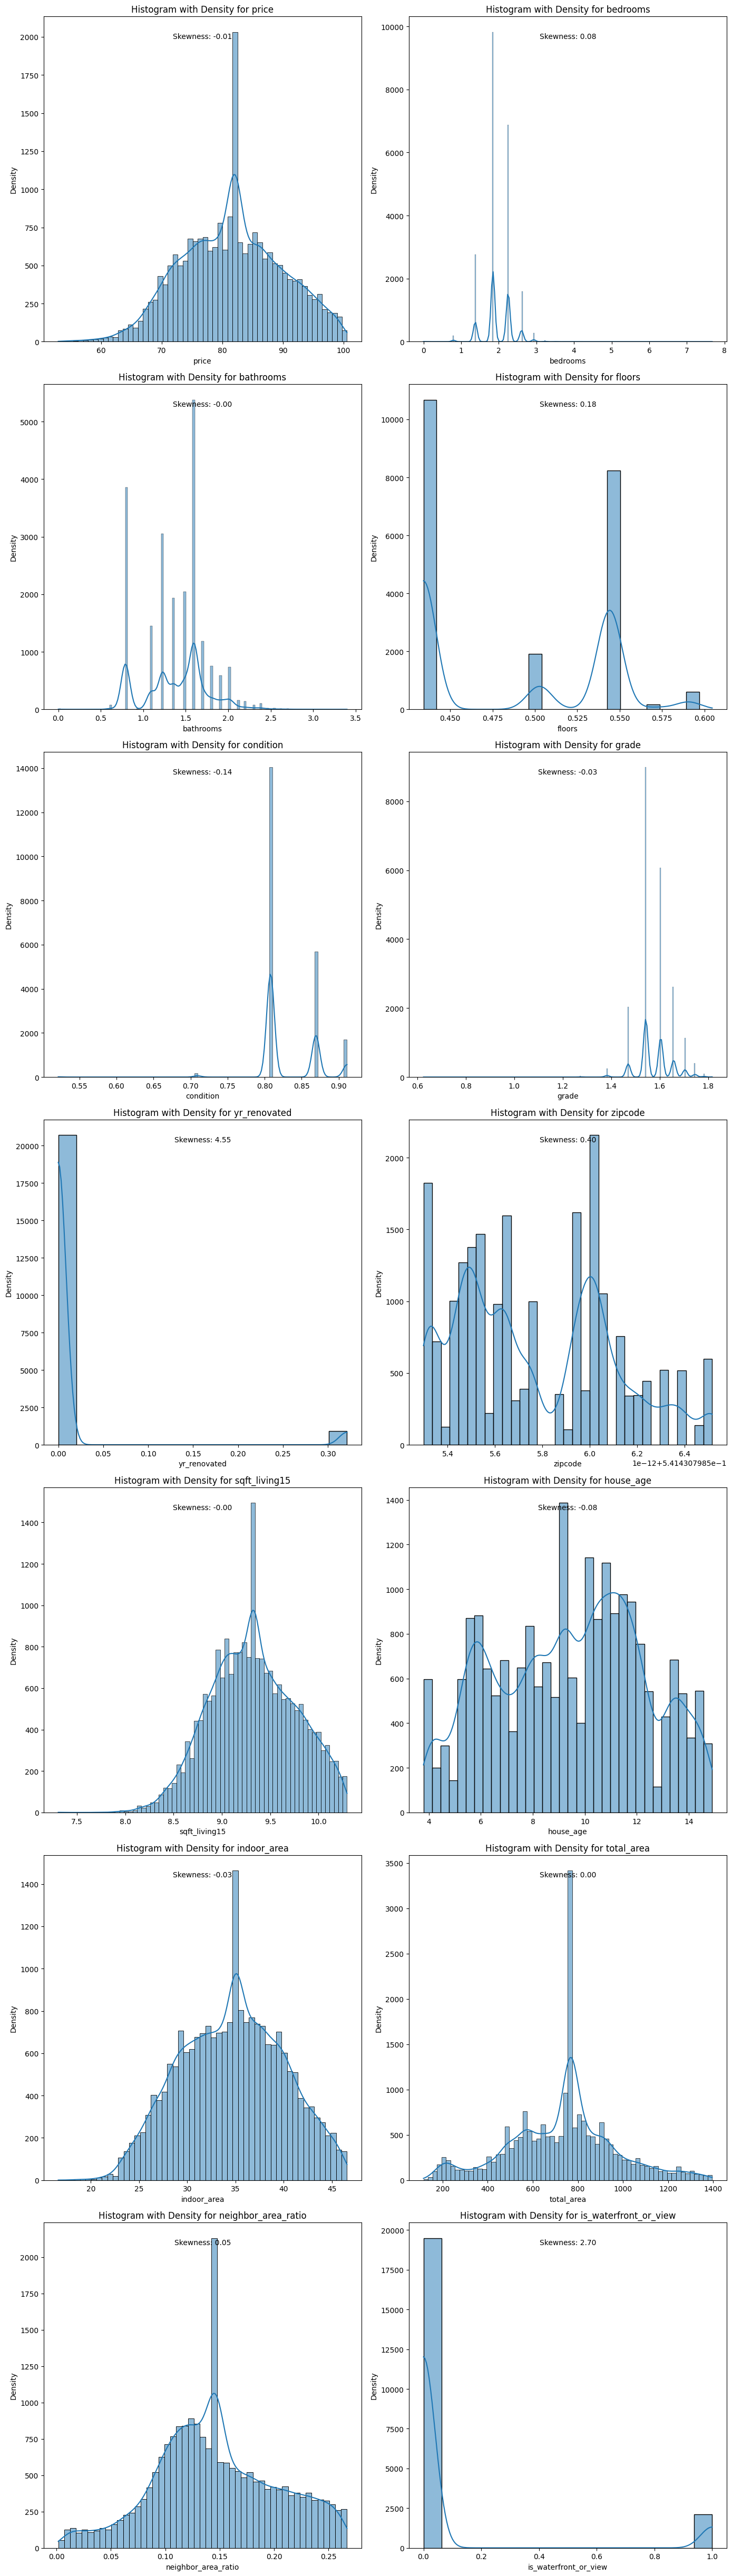

In [ ]:
df = yeojohnson_df


# Set the figure size and arrange plots horizontally in pairs
numerical_features = yeojohnson_df.select_dtypes(include=['number']).columns
num_plots = len(numerical_features)
num_rows = (num_plots + 1) // 2  # Ensure enough rows to accommodate all features
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(14, 7*num_rows))

# Flatten the axes array for easy indexing making it easier to iterate over the subplots using a single index.
axes = axes.flatten()

# Loop through the selected columns and create histograms with density
for i, col in enumerate(numerical_features):
    sns.histplot(data=yeojohnson_df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram with Density for {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

    # Calculate skewness
    skewness = skew(yeojohnson_df[col].dropna())
    axes[i].text(0.5, 0.95, f'Skewness: {skewness:.2f}', horizontalalignment='center', verticalalignment='top', transform=axes[i].transAxes)

# Remove any empty subplots if the number of features is odd
if num_plots % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Correlation Plot'}>

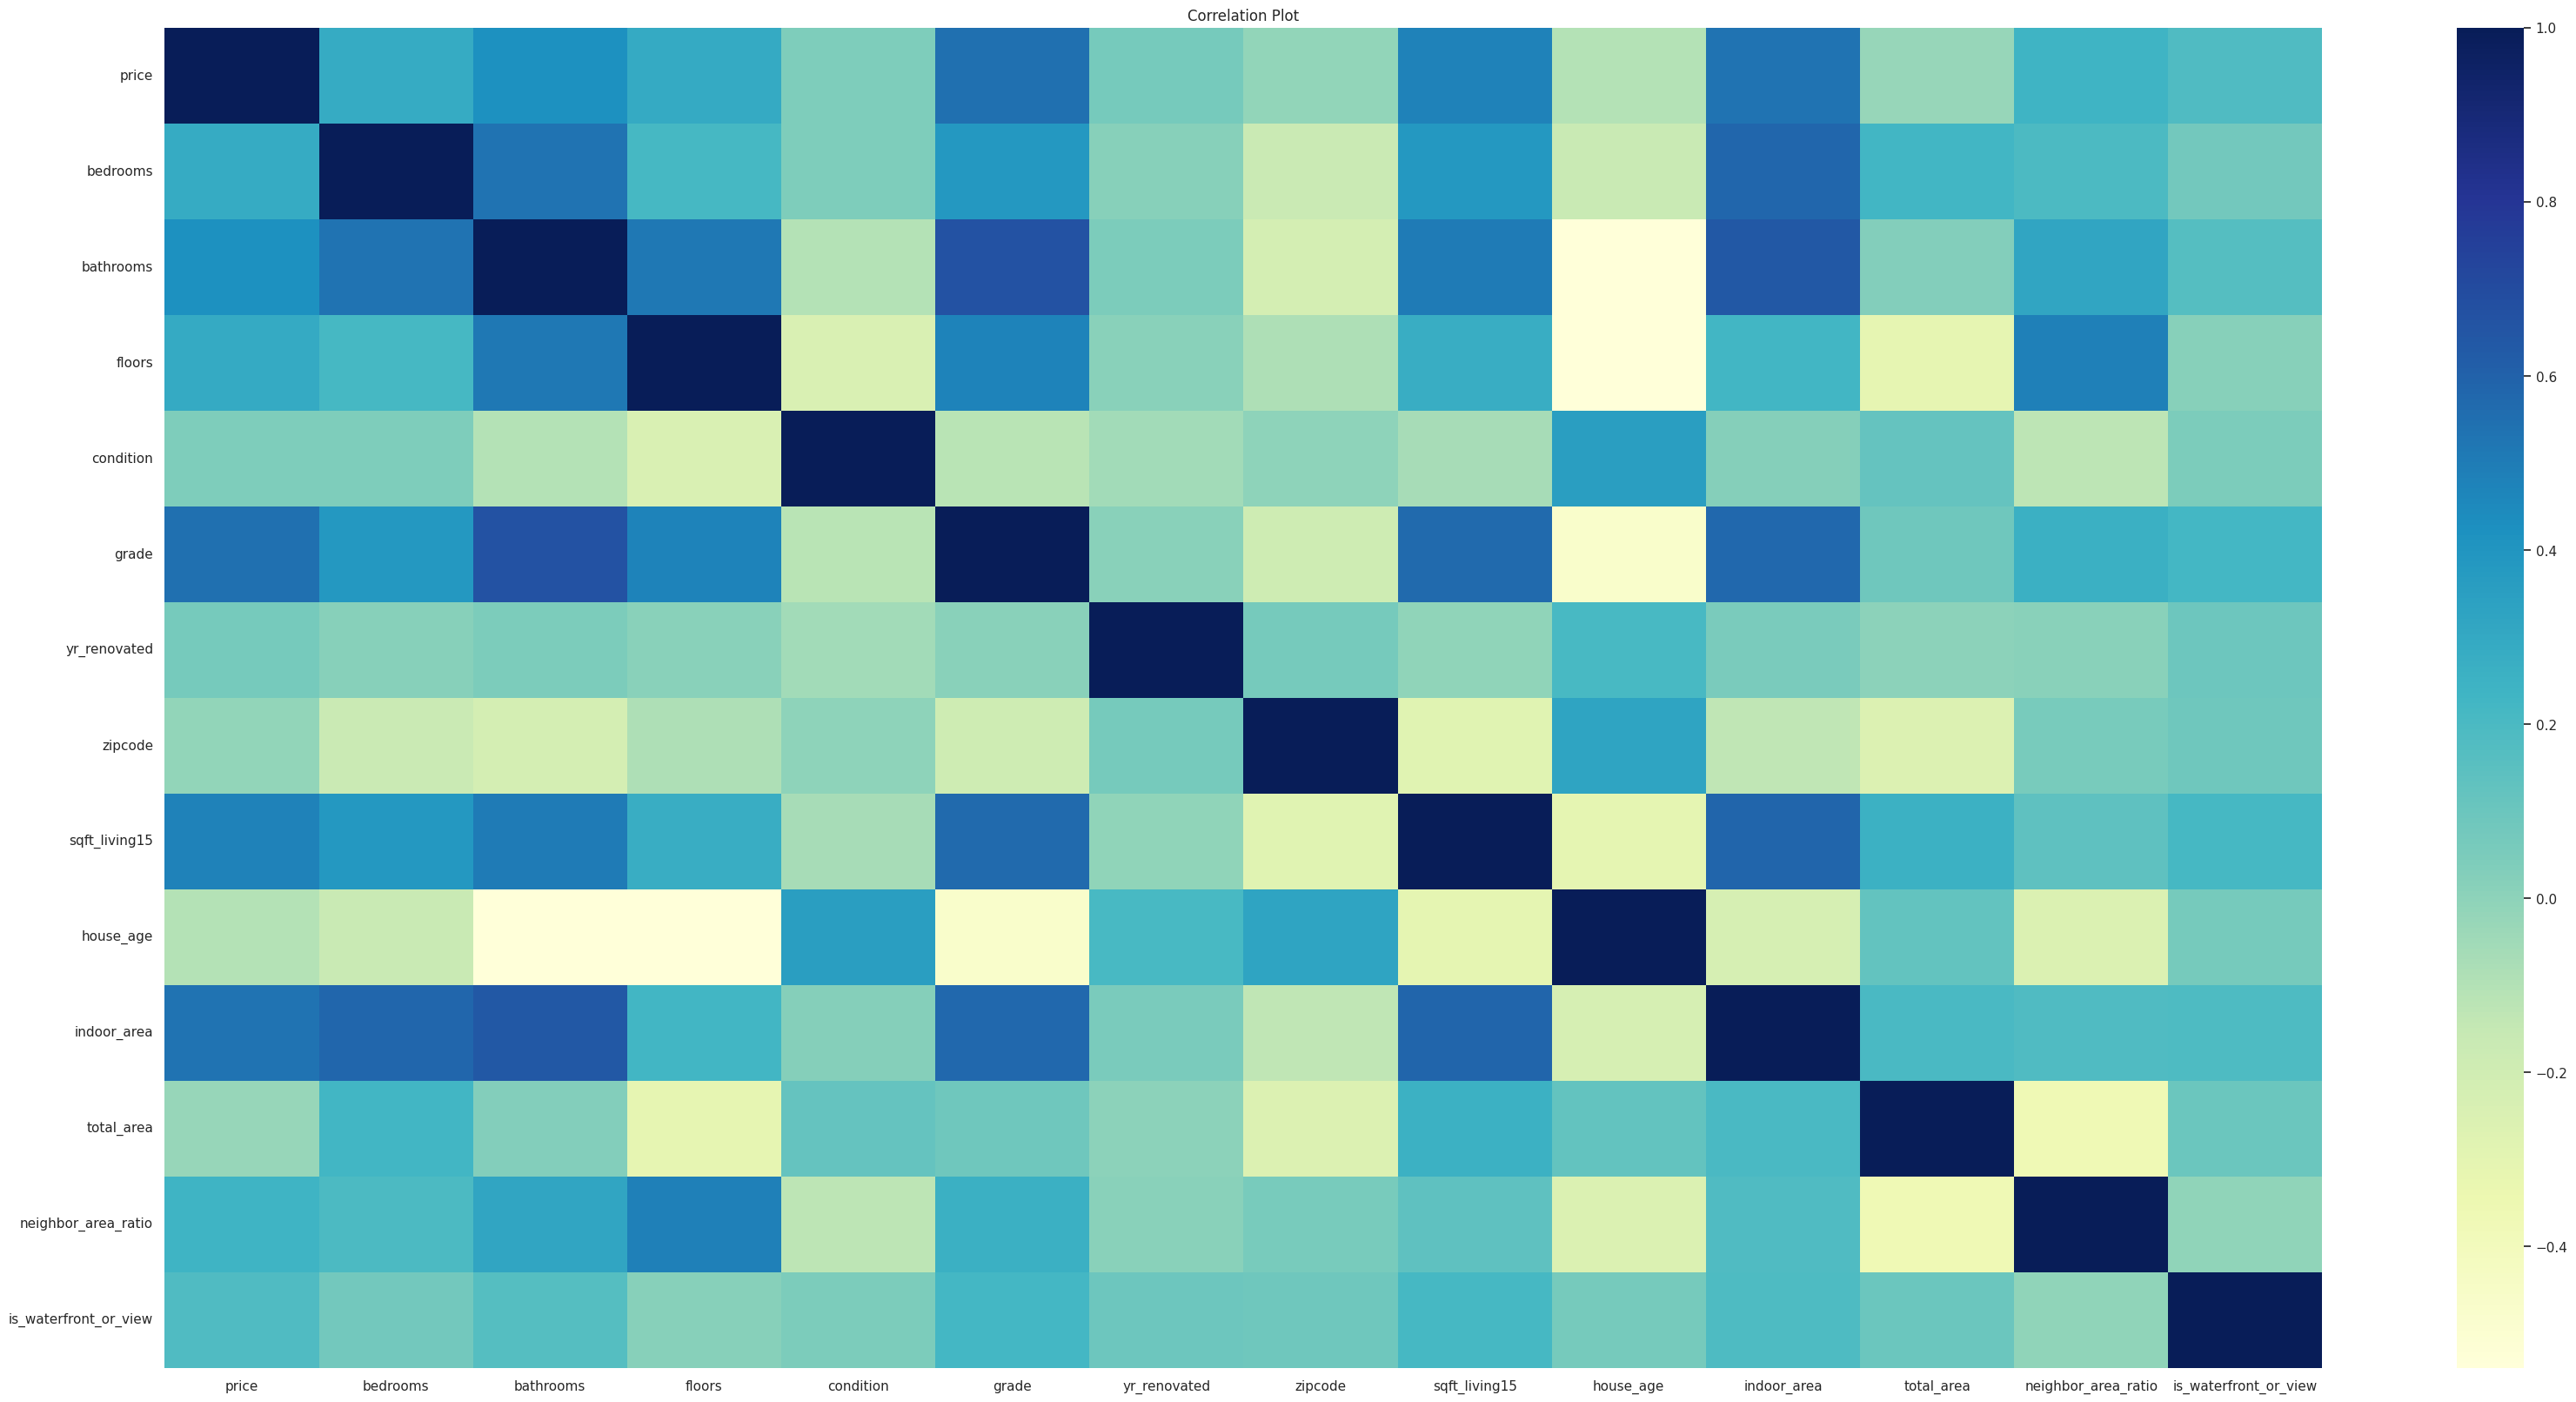

In [ ]:
plt.figure(figsize=(40,20))
plt.title("Correlation Plot")
sns.heatmap(df.corr(),cmap='YlGnBu')

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a mask to identify the features with a correlation coefficient greater than or equal to 0.75
high_correlation_mask = correlation_matrix >= 0.8

high_correlation_mask

,price,bedrooms,bathrooms,floors,condition,grade,yr_renovated,zipcode,sqft_living15,house_age,indoor_area,total_area,neighbor_area_ratio,is_waterfront_or_view
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,False,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,True,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,True,False,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,True,False,False,False,False,False,False,False,False
yr_renovated,False,False,False,False,False,False,True,False,False,False,False,False,False,False
zipcode,False,False,False,False,False,False,False,True,False,False,False,False,False,False
sqft_living15,False,False,False,False,False,False,False,False,True,False,False,False,False,False
house_age,False,False,False,False,False,False,False,False,False,True,False,False,False,False


In [ ]:
highly_correlated_features = []

for feature in high_correlation_mask.columns:
    correlated_with = high_correlation_mask.index[high_correlation_mask[feature]].tolist()
    for correlated_feature in correlated_with:
        if feature != correlated_feature and (correlated_feature, feature) not in highly_correlated_features:
            highly_correlated_features.append((feature, correlated_feature))

# Print the highly correlated features
print("Highly correlated features:")
if len(highly_correlated_features) == 0:
  print("None")
else:
  for feature1, feature2 in highly_correlated_features:
    print(f"{feature1} and {feature2}")

Highly correlated features:
None


**So no need to drop more columns (until now😄)**

<h1>PCA</h1>

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
X,y=df.drop('price',axis=1),df['price']
X.shape, y.shape

((21613, 13), (21613,))

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

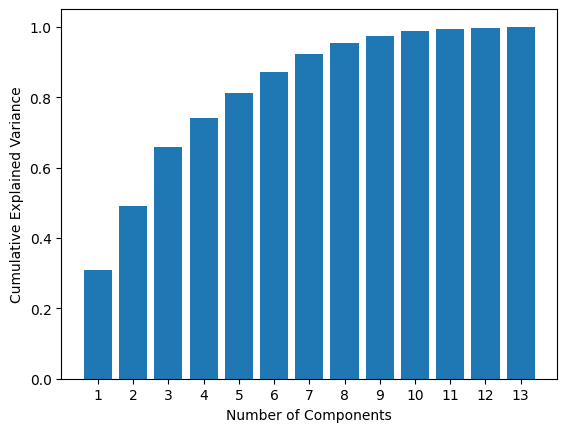

In [ ]:

pca = PCA()
pca.fit(X)  # X_train is your training data
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

x_values = np.arange(1, len(cumulative_variance_ratio) + 1)  # Labels for components starting from 1

plt.bar(x=x_values, height=cumulative_variance_ratio)
plt.xticks(ticks=x_values, labels=x_values)  # This sets labels for each bar
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [ ]:
n_components = np.argmax(cumulative_variance_ratio >= 0.8) + 1
components = pca.components_
feature_importance = np.abs(components[0])
print(feature_importance)

[0.037789   0.18513531 0.72055064 0.07239256 0.08563245 0.03677755
 0.18306069 0.15732036 0.48908873 0.1688291  0.12125092 0.30062319
 0.01137771]


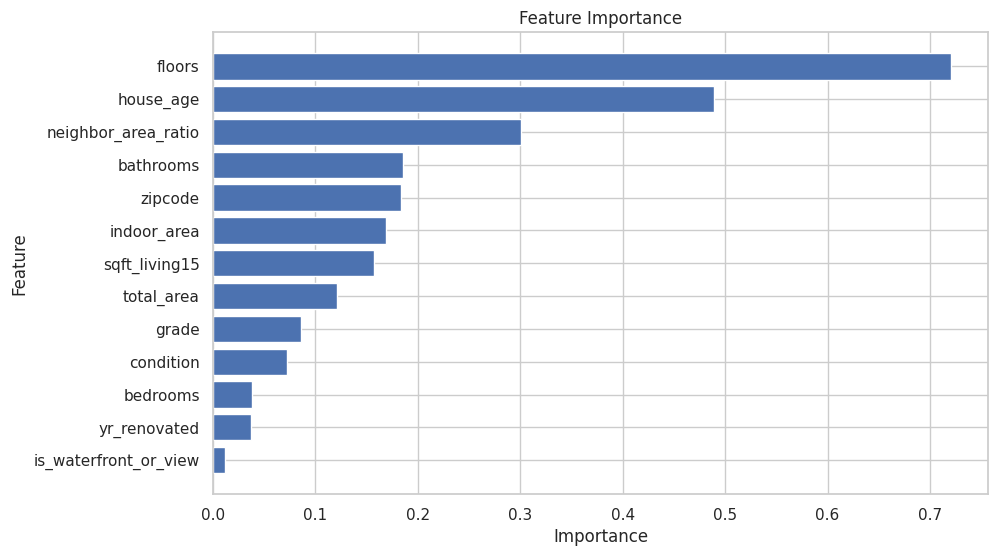

In [ ]:
feature_names = [col for col in df.columns if col != 'price']
sorted_importance, sorted_features = zip(*sorted(zip(feature_importance, feature_names)))

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importance)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
X_pca = pca.transform(X)[:, :6]
X_pca.shape

(21613, 6)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17290, 6), (4323, 6), (17290,), (4323,))

<h1>NEURAL NETWORK TRAINING</h1>

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
def r2_keras(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

In [ ]:


model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(2,activation='relu'))
model.add(Dense(1,activation='linear'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │              10 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,673 (6.54 KB)

 Trainable params: 1,673 (6.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error',metrics=[r2_keras])

In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_data = (X_test,y_test),verbose=True)

Epoch 1/100
  1/541 ━━━━━━━━━━━━━━━━━━━━ 11:05 1s/step - loss: 6653.4702 - r2_keras: -111.9852

541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1250.6674 - r2_keras: -20.2749 - val_loss: 45.4736 - val_r2_keras: 0.2845
Epoch 2/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 43.3768 - r2_keras: 0.3133 - val_loss: 39.8553 - val_r2_keras: 0.3621
Epoch 3/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 40.5547 - r2_keras: 0.3603 - val_loss: 38.8882 - val_r2_keras: 0.3724
Epoch 4/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 41.3113 - r2_keras: 0.3605 - val_loss: 44.9520 - val_r2_keras: 0.2688
Epoch 5/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 43.1689 - r2_keras: 0.3385 - val_loss: 39.5663 - val_r2_keras: 0.3630
Epoch 6/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 42.4718 - r2_keras: 0.3505 - val_loss: 40.3724 - val_r2_keras: 0.3620
Epoch 7/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 41.7739 - r2_keras: 0.3474 - val_loss: 38.0660 - val_r2_keras: 0.3999
Epoch 8/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 42.0900 - r2_keras: 0.3518 - v

In [ ]:
test_loss, test_R2 = model.evaluate(X_test,y_test)
print(f"Test Loss: {test_loss}")
print(f"R2_score: {test_R2}")

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 35.3421 - r2_keras: 0.4621
Test Loss: 35.02008819580078
R2_score: 0.43927544355392456


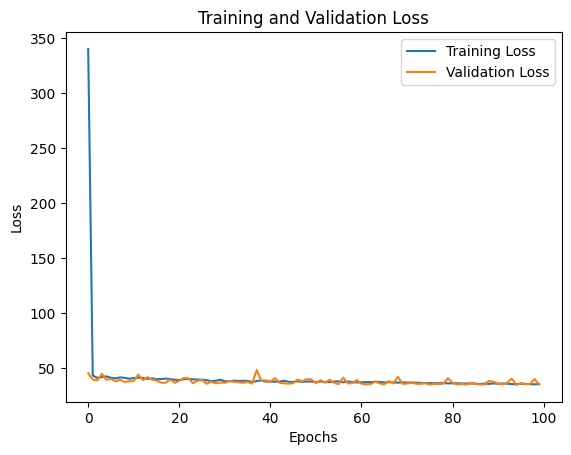

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

**I will consider hyperparameters tuning to try enhance my model**

In [ ]:
def build_model(hp: HyperParameters):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=16, max_value=128, step=16),
                    activation=hp.Choice('activation_1', ['relu', 'tanh']),
                    input_shape=(X_train.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', min_value=16, max_value=256, step=32),
        activation=hp.Choice('activation_2', ['relu', 'tanh'])
    ))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', min_value=8, max_value=64, step=8),
        activation=hp.Choice('activation_3', ['relu', 'tanh'])
    ))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_4', min_value=0, max_value=32, step=4),
        activation=hp.Choice('activation_4', ['relu', 'tanh'])
    ))
    model.add(Dropout(rate=hp.Float('dropout_4', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='linear'))

    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    batch_size = hp.Int('batch_size', min_value=32, max_value=512, step=32)

    if optimizer == 'adam':
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=[r2_keras])
    elif optimizer == 'rmsprop':
        model.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='mean_squared_error', metrics=[r2_keras])
    else:
        model.compile(optimizer=SGD(learning_rate=learning_rate), loss='mean_squared_error', metrics=[r2_keras])

    return model

# Defining the tuner with RandomSearch
tuner = RandomSearch(
    build_model,
    objective=keras_tuner.Objective("val_r2_keras", direction="max"),
    max_trials=7,
    executions_per_trial=5,
    directory='tuner_dir_2',
    project_name='tune_nn'
)

# Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_r2_keras',
    patience=10,
    restore_best_weights=True,
    mode='max'
)

# Perform the hyperparameter search
tuner.search(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=tuner.oracle.hyperparameters.get('batch_size'),
    callbacks=[early_stopping]
)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]


Trial 7 Complete [00h 08m 57s]
val_r2_keras: -0.02998110093176365

Best val_r2_keras So Far: 0.40365336537361146
Total elapsed time: 00h 46m 55s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.save('/content/drive/MyDrive/keras_houseprice_tunner/best_model.h5')

In [ ]:
import shutil
import os

folder_path = '/content/tuner_dir_2'

# Check if folder exists
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"{folder_path} has been deleted.")
else:
    print(f"{folder_path} does not exist.")


/content/tuner_dir_2 has been deleted.


In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 112)                 │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 48)                  │           5,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │           1,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,665 (41.66 KB)

 Trainable params: 10,665 (41.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for i, layer in enumerate(best_model.layers):
    config = layer.get_config()
    print(f"Layer {i}: {config['name']}")
    for key, value in config.items():
        print(f"  {key}: {value}")
    print("\n")


Layer 0: dense
  name: dense
  trainable: True
  dtype: {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}
  units: 16
  activation: relu
  use_bias: True
  kernel_initializer: {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}
  bias_initializer: {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}
  kernel_regularizer: None
  bias_regularizer: None
  kernel_constraint: None
  bias_constraint: None


Layer 1: dropout
  name: dropout
  trainable: True
  dtype: {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}
  rate: 0.1
  seed: None
  noise_shape: None


Layer 2: dense_1
  name: dense_1
  trainable: True
  dtype: {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}
  units: 208
  activation: tanh
  use_bias: True
  kernel_

In [ ]:
K.clear_session()
model = Sequential()

    # Layer 1
model.add(Dense(units=16, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(rate=0.1))

    # Layer 2
model.add(Dense(units=208, activation='tanh'))
model.add(Dropout(rate=0.3))

    # Layer 3
model.add(Dense(units=40, activation='tanh'))
model.add(Dropout(rate=0.2))

    # Layer 4
model.add(Dense(units=24, activation='relu'))
model.add(Dropout(rate=0.0))

    # Output Layer
model.add(Dense(units=1, activation='linear'))


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 208)                 │           3,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 208)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 40)                  │           8,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 24)                  │             984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 24)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,017 (50.85 KB)

 Trainable params: 13,017 (50.85 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mean_absolute_error'])

In [ ]:
early_stopping = EarlyStopping( monitor='val_loss', patience=15, restore_best_weights=True )

history = model.fit(X_train, y_train, epochs=100, validation_data = (X_test,y_test),verbose=True)

Epoch 1/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 6255.3418 - mean_absolute_error: 78.5389 - val_loss: 3827.9929 - val_mean_absolute_error: 61.3223
Epoch 2/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3282.2483 - mean_absolute_error: 56.4954 - val_loss: 1855.9015 - val_mean_absolute_error: 42.2904
Epoch 3/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1520.4888 - mean_absolute_error: 37.7602 - val_loss: 682.7979 - val_mean_absolute_error: 24.8104
Epoch 4/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 545.0128 - mean_absolute_error: 21.1887 - val_loss: 195.6526 - val_mean_absolute_error: 11.8757
Epoch 5/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 181.2847 - mean_absolute_error: 10.9940 - val_loss: 81.8674 - val_mean_absolute_error: 7.3267
Epoch 6/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 113.1254 - mean_absolute_error: 8.5276 - val_loss: 68.7483 - val_mean_absolute_error: 6.7034
Epoch 7/100
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - los

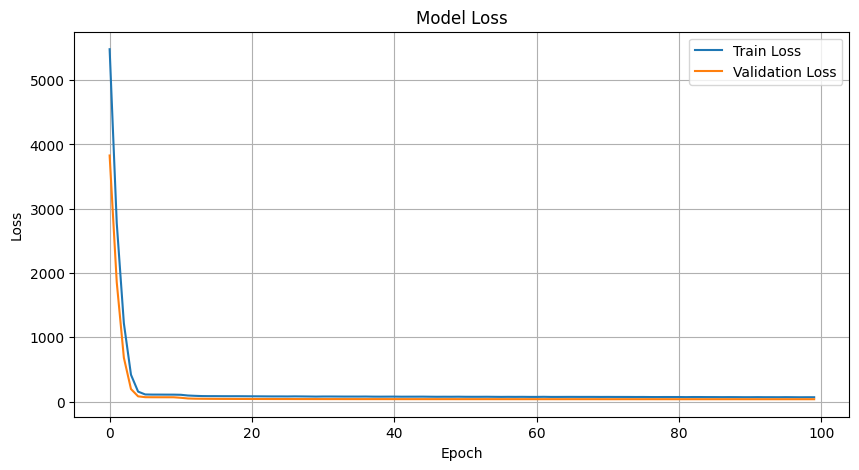

In [ ]:

plt.figure(figsize=(10, 5))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [ ]:
def predict_price(model, sample_input=None, features=None):
    if features is not None:
        pca = PCA()
        if features.ndim == 1:
            sample_input = pca.fit_transform(features.reshape(1, -1))[:, :6]
        else:
            sample_input = pca.fit_transform(features)[:, :6]

    if sample_input.ndim == 1:
        sample_input = sample_input.reshape(1, -1)

    prediction = model.predict(sample_input)

    if sample_input.shape[0] == 1:
        print(f"The predicted price is: {prediction[0][0]} $")
        return prediction[0][0]
    else:
        print("The predicted prices are: ", prediction.flatten())
        return prediction.flatten()



In [ ]:
price_scaler = MinMaxScaler()
price_scaler.fit(y_train.values.reshape(-1, 1))
prediction_arr = predict_price(model,features=X_test)
# Ensure prediction_arr has the correct shape
if prediction_arr.ndim == 1:
    prediction_arr = prediction_arr.reshape(-1, 1)

# Convert y_test to NumPy array if it's a pandas Series
y_test_array = y_test.values.reshape(-1, 1)

real_predictions = price_scaler.inverse_transform(prediction_arr)
real_actuals = price_scaler.inverse_transform(y_test_array.reshape(-1, 1))

# Create a DataFrame for better readability
comparison = pd.DataFrame(np.concatenate((real_predictions, real_actuals), axis=1), columns=['Predicted', 'Actual'])

print("First 10 Predictions and Actual Values:")
comparison.head(10)


First 10 Predictions and Actual Values:


,predictions,actual
0,3945.892578,3768.521064
1,4220.589355,4627.625115
2,4222.390137,4831.970663
3,4244.251465,3961.610685
4,4020.280762,4417.219118
5,3686.382080,3304.864105
6,4077.985840,4529.113312
7,4182.281738,4370.683534
8,3703.560059,3815.661980
9,3840.526855,4250.927819
